In [128]:
import fsspec
import pandas as pd
import seaborn as sns
import janitor

In [129]:
# instantiate an fsspec filesystem object w/ caching enabled
fs = fsspec.filesystem("filecache", target_protocol="https", cache_storage="/tmp/files")

# load the data from the remote URL
url = (
    "https://raw.githubusercontent.com/fivethirtyeight/data/master/college-majors/recent-grads.csv"
)
df = pd.read_csv(fs.open(url))

df

,Rank,Major_code,Major,Total,Men,Women,Major_category,ShareWomen,Sample_size,Employed,...,Part_time,Full_time_year_round,Unemployed,Unemployment_rate,Median,P25th,P75th,College_jobs,Non_college_jobs,Low_wage_jobs
0,1,2419,PETROLEUM ENGINEERING,2339.0,2057.0,282.0,Engineering,0.120564,36,1976,...,270,1207,37,0.018381,110000,95000,125000,1534,364,193
1,2,2416,MINING AND MINERAL ENGINEERING,756.0,679.0,77.0,Engineering,0.101852,7,640,...,170,388,85,0.117241,75000,55000,90000,350,257,50
2,3,2415,METALLURGICAL ENGINEERING,856.0,725.0,131.0,Engineering,0.153037,3,648,...,133,340,16,0.024096,73000,50000,105000,456,176,0
3,4,2417,NAVAL ARCHITECTURE AND MARINE ENGINEERING,1258.0,1123.0,135.0,Engineering,0.107313,16,758,...,150,692,40,0.050125,70000,43000,80000,529,102,0
4,5,2405,CHEMICAL ENGINEERING,32260.0,21239.0,11021.0,Engineering,0.341631,289,25694,...,5180,16697,1672,0.061098,65000,50000,75000,18314,4440,972
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168,169,3609,ZOOLOGY,8409.0,3050.0,5359.0,Biology & Life Science,0.637293,47,6259,...,2190,3602,304,0.046320,26000,20000,39000,2771,2947,743
169,170,5201,EDUCATIONAL PSYCHOLOGY,2854.0,522.0,2332.0,Psychology & Social Work,0.817099,7,2125,...,572,1211,148,0.065112,25000,24000,34000,1488,615,82
170,171,5202,CLINICAL PSYCHOLOGY,2838.0,568.0,2270.0,Psychology & Social Work,0.799859,13,2101,...,648,1293,368,0.149048,25000,25000,40000,986,870,622
171,172,5203,COUNSELING PSYCHOLOGY,4626.0,931.0,3695.0,Psychology & Social Work,0.798746,21,3777,...,965,2738,214,0.053621,23400,19200,26000,2403,1245,308


In [130]:
# set string to title case

df

,Rank,Major_code,Major,Total,Men,Women,Major_category,ShareWomen,Sample_size,Employed,...,Part_time,Full_time_year_round,Unemployed,Unemployment_rate,Median,P25th,P75th,College_jobs,Non_college_jobs,Low_wage_jobs
0,1,2419,PETROLEUM ENGINEERING,2339.0,2057.0,282.0,Engineering,0.120564,36,1976,...,270,1207,37,0.018381,110000,95000,125000,1534,364,193
1,2,2416,MINING AND MINERAL ENGINEERING,756.0,679.0,77.0,Engineering,0.101852,7,640,...,170,388,85,0.117241,75000,55000,90000,350,257,50
2,3,2415,METALLURGICAL ENGINEERING,856.0,725.0,131.0,Engineering,0.153037,3,648,...,133,340,16,0.024096,73000,50000,105000,456,176,0
3,4,2417,NAVAL ARCHITECTURE AND MARINE ENGINEERING,1258.0,1123.0,135.0,Engineering,0.107313,16,758,...,150,692,40,0.050125,70000,43000,80000,529,102,0
4,5,2405,CHEMICAL ENGINEERING,32260.0,21239.0,11021.0,Engineering,0.341631,289,25694,...,5180,16697,1672,0.061098,65000,50000,75000,18314,4440,972
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168,169,3609,ZOOLOGY,8409.0,3050.0,5359.0,Biology & Life Science,0.637293,47,6259,...,2190,3602,304,0.046320,26000,20000,39000,2771,2947,743
169,170,5201,EDUCATIONAL PSYCHOLOGY,2854.0,522.0,2332.0,Psychology & Social Work,0.817099,7,2125,...,572,1211,148,0.065112,25000,24000,34000,1488,615,82
170,171,5202,CLINICAL PSYCHOLOGY,2838.0,568.0,2270.0,Psychology & Social Work,0.799859,13,2101,...,648,1293,368,0.149048,25000,25000,40000,986,870,622
171,172,5203,COUNSELING PSYCHOLOGY,4626.0,931.0,3695.0,Psychology & Social Work,0.798746,21,3777,...,965,2738,214,0.053621,23400,19200,26000,2403,1245,308


Header | Description
---|---------
`Rank` | Rank by median earnings
`Major_code` | Major code, FO1DP in ACS PUMS
`Major` | Major description
`Major_category` | Category of major from Carnevale et al
`Total` | Total number of people with major
`Sample_size` | Sample size (unweighted) of full-time, year-round ONLY (used for earnings)
`Men` | Male graduates
`Women` | Female graduates
`ShareWomen` | Women as share of total
`Employed` | Number employed (ESR == 1 or 2)
`Full_time` | Employed 35 hours or more
`Part_time` | Employed less than 35 hours
`Full_time_year_round` | Employed at least 50 weeks (WKW == 1) and at least 35 hours (WKHP >= 35)
`Unemployed` | Number unemployed (ESR == 3)
`Unemployment_rate` | Unemployed / (Unemployed + Employed)
`Median` | Median earnings of full-time, year-round workers
`P25th` | 25th percentile of earnings
`P75th` | 75th percentile of earnings
`College_jobs` | Number with job requiring a college degree
`Non_college_jobs` | Number with job not requiring a college degree
`Low_wage_jobs` | Number in low-wage service jobs

In [131]:
# set major column values to title case
df["Major"] = df["Major"].str.title()


### Distribution of Median Earnings

let's start by looking at the distribution of the median salaries. 


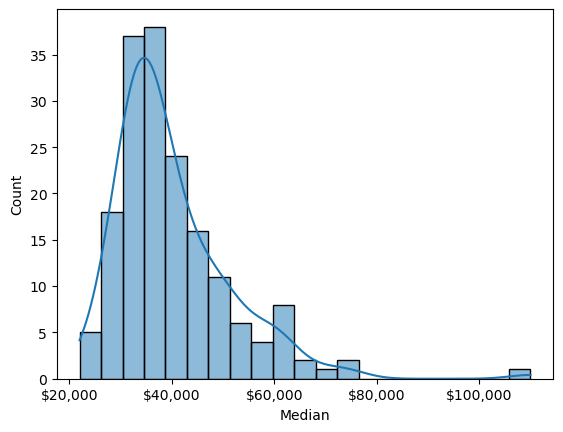

In [132]:
ax = sns.histplot(data=df, x="Median", kde=True)
ax.xaxis.set_major_formatter('${x:,.0f}')

It appears that the median salary for recent college graduates is around $35,000. The distribution is skewed to the right, with a few outliers on the high end.




### Variability in the median salary depending on the sample size 

The plot below shows the median salary for each major category. We can see that the median salary for majors with a small sample size is more variable. The median salary for majors with a large sample size is more stable. As a result, we can drop the majors with a small sample size to get a more stable estimate of the median salary for each major category.

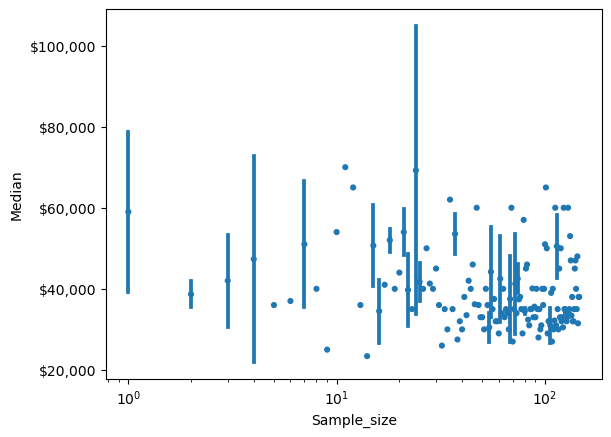

In [133]:
ax = sns.pointplot(
    data=df, y="Median", x="Sample_size", join=False, markers="o", scale=0.5, errorbar="sd"
)
ax.yaxis.set_major_formatter('${x:,.0f}')
ax.set_xscale('log')

In [134]:
# df = df.filter_on("Sample_size > 100")

### What categories of majors have the highest and lowest median salaries?


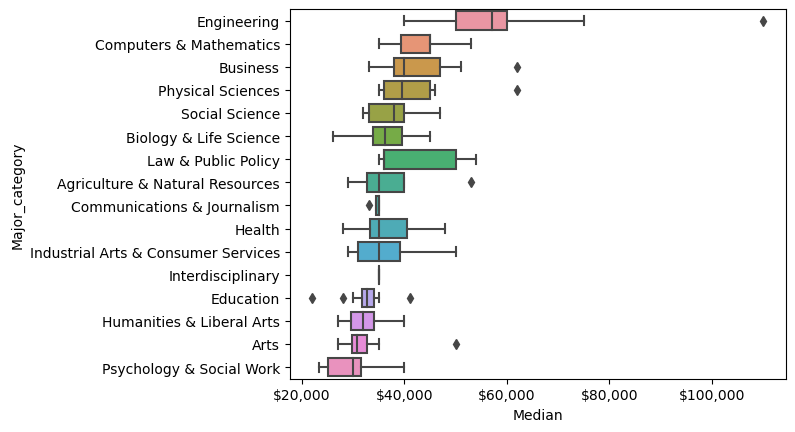

In [135]:
order = df.groupby("Major_category")['Median'].median().sort_values(ascending=False).index
ax = sns.boxplot(data=df, x="Median", y="Major_category", order=order)
ax.xaxis.set_major_formatter('${x:,.0f}')

This plot shows the distribution of median salaries by major category. The plot is sorted by the median salary of each major category. We can see that the median salary for engineering majors is the highest, followed by business and computer science. The lowest median salary is for the arts category.


### What are the highest paying majors?

In [136]:
majors_data = df[
    ['Major', 'Major_category', 'Median', 'P25th', 'P75th', 'Sample_size']
].sort_values(by='Median', ascending=False)

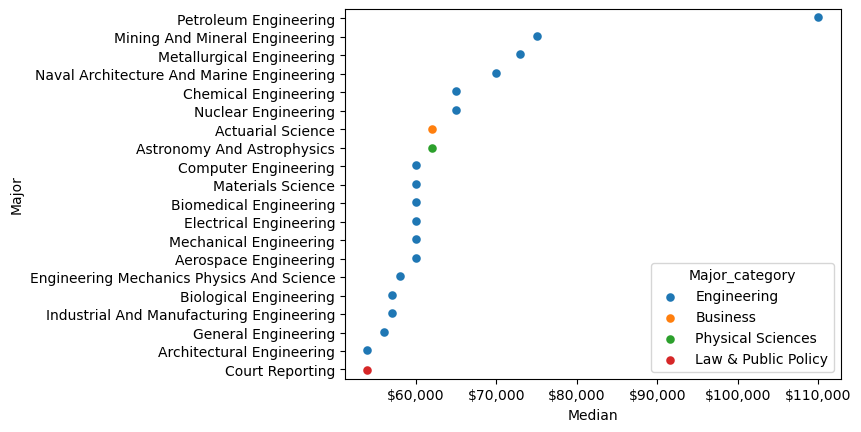

In [137]:
ax = sns.pointplot(
    data=majors_data.head(20),
    x="Median",
    y="Major",
    hue="Major_category",
    dodge=True,
    join=False,
    markers="o",
    scale=0.7,
)
ax.xaxis.set_major_formatter('${x:,.0f}');

The highest paying majors are petroleum engineering, mining and mineral engineering and other related majors. Petroleum engineering major appears to have the majority of outliers on the high end of the salary distribution. The plot also shows that most of the majors in the top 20 are engineering majors.

### What are the lowest paying majors?



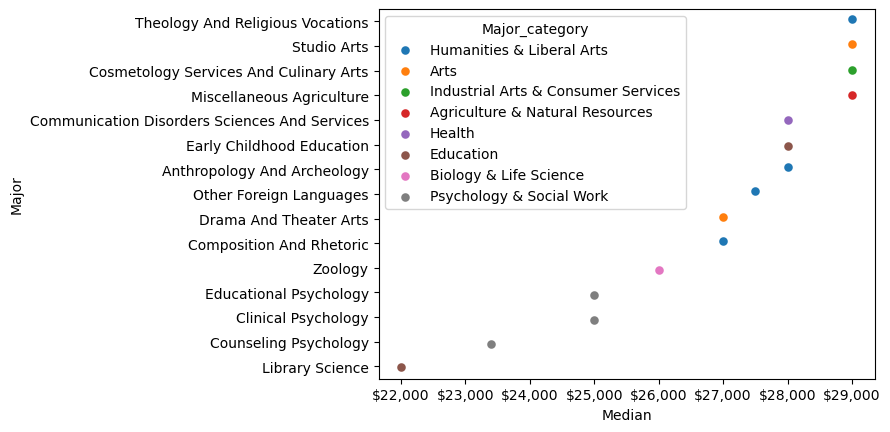

In [138]:
ax = sns.pointplot(
    data=majors_data.tail(15),
    x="Median",
    y="Major",
    hue="Major_category",
    dodge=True,
    join=False,
    markers="o",
    scale=0.7,
)
ax.xaxis.set_major_formatter('${x:,.0f}');

The median salary for the lowest paying majors is around $25,000 - $28,000. The lowest paying majors are in the arts category. 

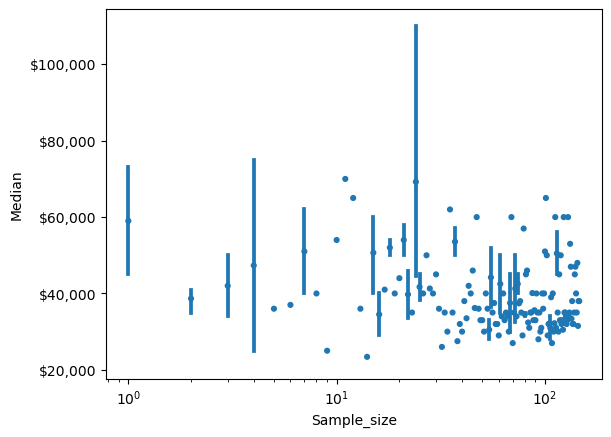

In [139]:
ax = sns.pointplot(
    data=majors_data, y="Median", x="Sample_size", join=False, markers="o", scale=0.5
)
ax.yaxis.set_major_formatter('${x:,.0f}')
ax.set_xscale('log')

### What are the most common majors?

Text(0.5, 0, 'Number of Graduates by Category')

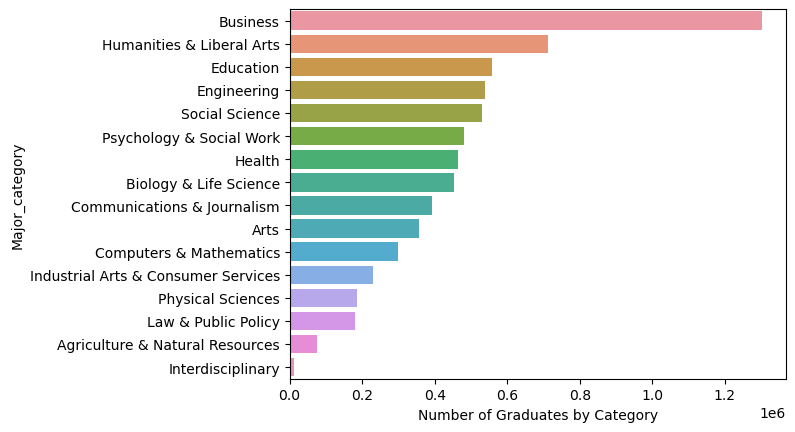

In [153]:
category_count = df.groupby("Major_category")['Total'].sum().sort_values(ascending=False)
ax = sns.barplot(y=category_count.index, x=category_count.values)
ax.set_yticklabels(ax.get_yticklabels())
ax.set_xlabel("Number of Graduates by Category")